**This notebook overviews and transforms the raw data, notes the selected analysis scope, detects and handles abnormal data.**

In [1]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid", palette = 'dark')

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Generate separated tracking data via code below before using these local modules
import tackle_plot
import get_data

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
games_all = pd.read_csv('../rawdata/games.csv')
tackles_all = pd.read_csv('../rawdata/tackles.csv')
players_all = pd.read_csv('../rawdata/players.csv')
plays_all = pd.read_csv('../rawdata/plays.csv')

In [3]:
tracking_data = {}
for i in range(9):
    w = i + 1
    tracking_data[w] = pd.read_csv(f'../rawdata/tracking_week_{w}.csv')

### Separate tracking data by dates to improve plotting speed

In [4]:
all_dates = games_all.gameDate.unique()

In [5]:
all_dates

array(['09/08/2022', '09/11/2022', '09/12/2022', '09/15/2022',
       '09/18/2022', '09/19/2022', '09/22/2022', '09/25/2022',
       '09/26/2022', '09/29/2022', '10/02/2022', '10/03/2022',
       '10/06/2022', '10/09/2022', '10/10/2022', '10/13/2022',
       '10/16/2022', '10/17/2022', '10/20/2022', '10/23/2022',
       '10/24/2022', '10/27/2022', '10/30/2022', '10/31/2022',
       '11/03/2022', '11/06/2022', '11/07/2022'], dtype=object)

In [6]:
%%time
for date in all_dates:
    week = games_all[games_all['gameDate'] == date]['week'].iloc[0]
    date_format = date.replace('/', '')
    date_id = date_format[4:] + date_format[:4]
    tracking = tracking_data[week]
    tracking['date_id'] = tracking['gameId'].apply(lambda x: str(x)[:8])
    tracking_sub = tracking[tracking['date_id']== date_id]
    tracking_sub = tracking_sub.drop(columns = ['date_id'])
    tracking_sub.to_csv(f'../newdata/{date_format}.csv', index = False)

### Plot function

In [7]:
def plot(gameId, playId):
    game = get_data.game(gameId)
    play = get_data.play(gameId, playId)
    tracking = get_data.tracking(gameId, playId).reset_index()
    
    date = game['gameDate'].item()
    tacklers = get_data.tacklers(gameId, playId)
    carrier = play['ballCarrierId'].item()
    offense = play['possessionTeam'].item()
    defense = play['defensiveTeam'].item()
    down = play['down'].item()
    yardstogo = play['yardsToGo'].item()
    ablos = play['absoluteYardlineNumber'].item()    
    
    return tackle_plot.plot(tracking, date, tacklers, carrier, offense, defense, down, yardstogo, ablos) 

### play data

- Get all play types from 'playDescription'

In [8]:
plays_all['action'] = plays_all['playDescription'].apply(
    lambda x: re.findall(r'\b[a-zA-Z\'-]+\.[a-zA-Z\'-]+\s([^.]+)\sto\b', x))

In [9]:
plays_all['action'] = plays_all.apply(
    lambda row: re.findall(r'\b[a-zA-Z\'-]+\.[a-zA-Z\'-]+\s([^.]+)\spushed', row['playDescription'])
                                   if row['action'] == [] else row['action'], axis = 1)

In [10]:
plays_all['action'] = plays_all.apply(
    lambda row: re.findall(r'\b[a-zA-Z\'-]+\.[a-zA-Z\'-]+\s([^.]+)\sran', row['playDescription'])
                                   if row['action'] == [] else row['action'], axis = 1)

In [11]:
plays_all['action'] = plays_all.apply(
    lambda row: re.findall(r'\b[a-zA-Z\'-]+\.[a-zA-Z\'-]+\s([^.]+)\sfor\b', row['playDescription'])
                                   if row['action'] == [] else row['action'], axis = 1)

In [12]:
plays_all['action'] = plays_all['action'].apply(lambda x: x[0] if x else None)
plays_all['action'] = plays_all.apply(lambda row: 'scramble' 
                                   if 'scrambles' in row['playDescription']
                                   else row['action'], axis = 1)

In [13]:
plays_all['action'].isna().sum()

5

In [14]:
plays_all['action'].value_counts()

action
pass short right                      2049
pass short left                       1864
up the middle                         1536
pass short middle                     1120
left tackle                            838
left end                               831
right tackle                           815
right guard                            814
right end                              769
left guard                             764
scramble                               471
pass deep right                        227
pass deep left                         226
pass deep middle                       145
pass incomplete short right              2
to SEA 37                                1
to NO 5                                  1
lines up behind center and pitches       1
to SF 15                                 1
to KC 10                                 1
up the middle tackled in End Zone        1
left guard tackled in End Zone           1
pass incomplete deep left                1
to B

- **Pick 'pass short' play type as the focused scope of this project**

In [15]:
plays_ps = plays_all[plays_all['playDescription'].str.contains('pass short', regex = False, na = False)]

### tackle data

In [16]:
tackles_all.shape

(17426, 7)

In [17]:
tackles_all.isna().sum()

gameId              0
playId              0
nflId               0
tackle              0
assist              0
forcedFumble        0
pff_missedTackle    0
dtype: int64

In [18]:
tackles_all[['tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].value_counts()

tackle  assist  forcedFumble  pff_missedTackle
1       0       0             0                   9810
0       1       0             0                   5428
        0       0             1                   2013
1       0       1             0                     74
0       1       0             1                     42
1       0       0             1                     34
0       1       1             0                     24
1       0       1             1                      1
Name: count, dtype: int64

### tackle & play & tracking data

In [19]:
def standardize_tracking(tracking):
    """
    Standardize data so all plays are seen as played from left to right

    Parameters:
    df1 (DataFrame): tracking data of one selected play.
    Returns:
    df1 (DataFrame): standardized tracking data of one selected play.
    """
    if tracking.at[0, 'playDirection'] == 'left':
        tracking['playDirection'] = 'right'
        tracking['x'] = 120-tracking['x']
        tracking['y'] = 53.3-tracking['y']  
        tracking['dir'] = (tracking['dir'] + 180) % 360
        tracking['o'] = (tracking['o'] + 180) % 360
    return tracking

In [20]:
# Combine short pass play data and tackle data
plays_tackle = pd.merge(plays_ps, tackles_all, on = ['gameId', 'playId'], how = 'left')

In [21]:
plays_tackle.shape

(6630, 41)

In [22]:
plays_tackle[['tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].value_counts()

tackle  assist  forcedFumble  pff_missedTackle
1.0     0.0     0.0           0.0                 4264
0.0     1.0     0.0           0.0                 1372
        0.0     0.0           1.0                  726
1.0     0.0     1.0           0.0                   33
0.0     1.0     0.0           1.0                   20
1.0     0.0     0.0           1.0                   15
0.0     1.0     1.0           0.0                   14
1.0     0.0     1.0           1.0                    1
Name: count, dtype: int64

In [23]:
plays_tackle[['gameId', 'playId', 'nflId', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].isna().sum()

gameId                0
playId                0
nflId               185
tackle              185
assist              185
forcedFumble        185
pff_missedTackle    185
dtype: int64

- Check if tracking data of each play has one and only one 'pass_outcome_caught' event at frameId == 6

In [24]:
for idx, row in plays_ps.iterrows():
    
    gameId, playId = row['gameId'], row['playId']
    game_week = games_all[games_all['gameId'] == gameId]['week'].item()
    
    tracking_w = tracking_data[game_week]    
    tracking = tracking_w[(tracking_w['gameId'] == gameId) & 
                          (tracking_w['playId'] == playId)].reset_index(drop = True)
    # Standardize data so all plays are seen as played from left to right
    if tracking.at[0, 'playDirection'] == 'left':
        tracking['x'] = 120-tracking['x']
        tracking['y'] = 53.3-tracking['y']  
        tracking['dir'] = (tracking['dir'] + 180) % 360
        
    events = tracking[['frameId', 'event']].dropna(subset=['event']).drop_duplicates()
    caughts = events[events['event'] == 'pass_outcome_caught']
    if len(caughts) != 1 or caughts.frameId.to_list()[0] != 6:
        print(gameId, playId)

2022110608 2351


This play has two 'pass_outcome_caught' in the tracking data, the second one at frameId = 32 better fits the analysis purposes.

- Check carrier data at caught moments

In [25]:
carrier_caught_all_df = pd.DataFrame()
for idx, row in plays_ps.iterrows():
    
    gameId, playId = row['gameId'], row['playId']
    game_week = games_all[games_all['gameId'] == gameId]['week'].item()
    carrier = row['ballCarrierId']
    
    tracking_w = tracking_data[game_week]    
    tracking = tracking_w[(tracking_w['gameId'] == gameId) & 
                          (tracking_w['playId'] == playId)].reset_index(drop = True)
    tracking = standardize_tracking(tracking)
        
    caught_frm = 6
    # Note the special case
    if gameId == 2022110608 and playId == 2351:
        caught_frm = 32
    caught_df = tracking[tracking['frameId'] == caught_frm]
    carrier_caught_df = caught_df[caught_df['nflId'] == carrier]
    carrier_caught_all_df = pd.concat([carrier_caught_all_df, carrier_caught_df])
    
carrier_caught_all_df = carrier_caught_all_df.reset_index(drop = True)

In [26]:
carrier_caught_all_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,date_id
0,2022100908,3537,48723.0,Parker Hesse,6,2022-10-09 15:43:13.799999,46.0,ATL,right,57.48,24.58,3.30,1.62,0.32,45.64,72.68,pass_outcome_caught,20221009
1,2022091111,1148,42547.0,Darren Waller,6,2022-09-11 17:12:12.900000,83.0,LV,right,51.68,26.42,6.76,0.78,0.68,352.88,28.00,pass_outcome_caught,20220911
2,2022103001,2165,54616.0,Tyler Allgeier,6,2022-10-30 14:51:22.500000,25.0,ATL,right,22.95,35.01,6.69,0.55,0.67,84.54,30.93,pass_outcome_caught,20221030
3,2022092511,2903,46096.0,Rashaad Penny,6,2022-09-25 18:38:56.799999,20.0,SEA,right,31.01,43.47,5.39,2.71,0.54,70.02,31.77,pass_outcome_caught,20220925
4,2022091102,3336,46331.0,Ross Dwelley,6,2022-09-11 15:32:44.000000,82.0,SF,right,46.24,29.01,2.29,2.78,0.20,200.56,28.01,pass_outcome_caught,20220911


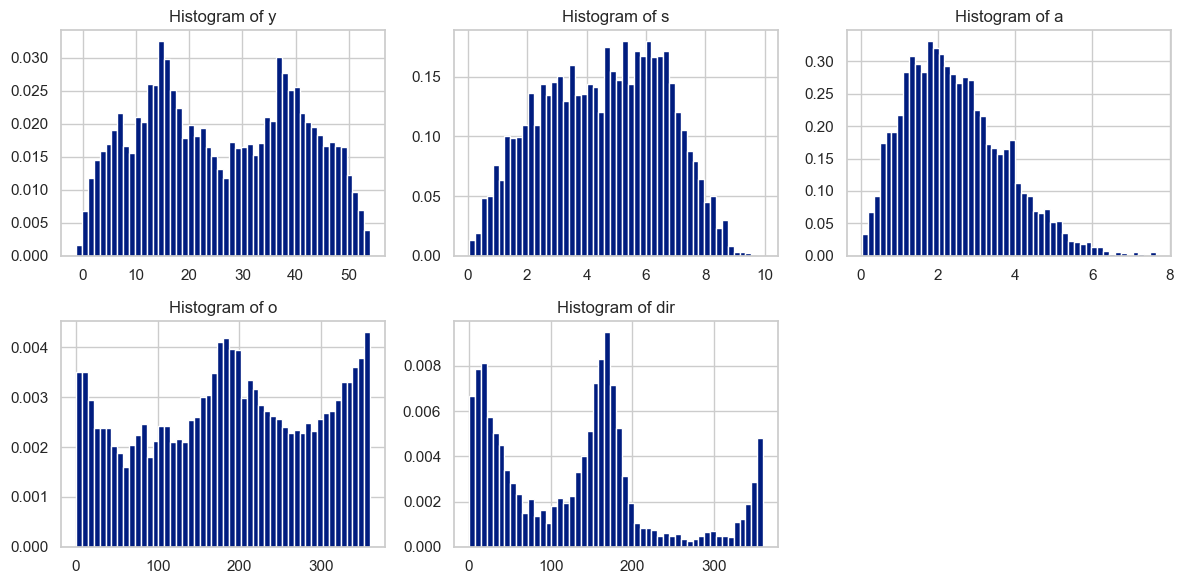

In [27]:
plt.figure(figsize=(12, 6))

for i, col in enumerate(['y', 's', 'a', 'o', 'dir']):
    plt.subplot(2, 3, i+1)
    plt.hist(carrier_caught_all_df[col], bins=50, density=True)
    plt.title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

- Check if any tacklers in record was never close to ballcarrier suring the whole play

In [28]:
plays_tackle_has_t = plays_tackle[~plays_tackle.nflId.isna()]

In [29]:
far_tacklers_idx = []
for idx, row in plays_tackle_has_t.iterrows():

    gameId, playId = row['gameId'], row['playId']
    game_week = games_all[games_all['gameId'] == gameId]['week'].item()
    carrier = row['ballCarrierId']
    tackler = row['nflId']
    tackler_name = get_data.name(tackler)
    
    tracking_w = tracking_data[game_week]    
    tracking = tracking_w[(tracking_w['gameId'] == gameId) & 
                          (tracking_w['playId'] == playId)].reset_index(drop = True)
    tracking = standardize_tracking(tracking)
    
    # Get events and corresponding frameIds
    events = tracking[['frameId', 'event']].dropna(subset=['event']).drop_duplicates().sort_values(by = 'frameId')
    caught_frm = 6
    lst_event = events.event.to_list()[-1]
    lst_event_frm = events.frameId.to_list()[-1]    
    
    # Get distance between recorded tackler and ballcarrier from when the ball is caught to the end
    df_t = tracking[tracking['nflId'] == tackler]
    df_c = tracking[tracking['nflId'] == carrier]
    df_tc = pd.merge(df_t[['gameId', 'playId', 'frameId','x', 'y', 'dir', 's']], df_c[['frameId', 'x', 'y', 'dir', 's']], 
                  on = 'frameId', how = 'outer', suffixes = ('_t', '_c'))     
    df_tc = df_tc.iloc[6:lst_event_frm, :]
    df_tc['dist'] = df_tc.apply(lambda row: math.dist([row['x_t'], row['y_t']], [row['x_c'], row['y_c']]), axis = 1)
    if df_tc['dist'].min() > 5:
        far_tacklers_idx.append(idx)
#         print(gameId, playId, tackler, tackler_name)
#         print(tackles_all[(tackles_all['gameId'] == gameId) & (tackles_all['playId'] == playId)])
#         plot(gameId, playId)

In [30]:
len(far_tacklers_idx)

34

In 34 plays, the recorded tackler was more than 5 yards from the ball carrier through the whole play. The details of those plays indicate causes such as: tracker malfunction, wrongly labeled for unknown reason, tackler not tackling ballcarrier, etc. All cases were deviate from analysis purposes and should be removed from the data for this analysis.

In [31]:
plays_tackle_has_t.loc[far_tacklers_idx][
    ['gameId', 'playId', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].head()

,gameId,playId,tackle,assist,forcedFumble,pff_missedTackle
64,2022092600,4008,0.0,0.0,0.0,1.0
219,2022100208,407,0.0,0.0,0.0,1.0
535,2022092505,1677,0.0,0.0,0.0,1.0
1168,2022092510,2798,0.0,0.0,0.0,1.0
1529,2022110604,3047,0.0,0.0,0.0,1.0


In [32]:
plays_tackle_has_t.loc[far_tacklers_idx][['tackle', 'assist', 'forcedFumble', 'pff_missedTackle']].value_counts()

tackle  assist  forcedFumble  pff_missedTackle
0.0     0.0     0.0           1.0                 25
1.0     0.0     0.0           0.0                  9
Name: count, dtype: int64

In [33]:
plays_tackle = plays_tackle.drop(far_tacklers_idx)

In [34]:
# plays_tackle.to_csv('../newdata/plays_tackle.csv', index = False)